[Update] 2/17
- 多次元尺度法の部分にミスがあったため修正しました。
- 使用するデータを180秒以内から全てに変更しました。
- 今後の取り組みを追加しました。

# はじめに


このディスカッションでは、ダイクストラ法を用いてcategory同士の距離行列を作成します。  
OneHotEncodingやLabelEncodingとは違い、category毎の「繋がり」を含めた情報を密なベクトルで表現できるためより多くの情報をモデルに伝えることができるようになります。

## やり方

1. グラフを作る
    - ノード: 一つ一つのcategory
    - エッジ: category1をカートに入れた後にcategory2をカートに入れた場合にエッジをつなげます.
    - 重み(距離): (category1からcategory2に遷移するまでの時間の中央値) / (category1からcategory2という遷移が起こった回数)
2. 距離行列の作成  
1で作成したグラフを用いて、category1からcategory2への距離をその最短経路長として距離行列を作成します。

## Import

In [1]:
# !pip install networkx

In [2]:
from pathlib import Path
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from tqdm.notebook import tqdm
from sklearn.manifold import MDS

import networkx as nx
warnings.simplefilter('ignore')

## Load

In [3]:
INPUT_DIR = Path('../input')

log_df = pd.read_csv(INPUT_DIR/'cart_log.csv')

In [4]:
log_df = pd.read_csv(INPUT_DIR/'cart_log.csv')
product_df = pd.read_csv(INPUT_DIR/'product_master.csv')
log_df = log_df.merge(product_df, how='left', on=['JAN'])
# log_df = log_df[log_df['duration']<180].reset_index(drop=True).copy()
log_df = log_df.dropna(subset=['category']) # categoryがnullのものは削除

## 1. グラフを作る

In [5]:
log_df[['prev_category', 'prev_duration']] = log_df.groupby('session_id')[['category', 'duration']].shift(1)
log_df['travel_time'] = log_df['duration'] - log_df['prev_duration']

graph_df = log_df.groupby(['prev_category', 'category'])['travel_time'].agg({'median', 'count'}).reset_index()
graph_df = graph_df.reset_index(drop=True)
graph_df['dist'] = graph_df['median'] / (graph_df['count'])

display(graph_df[['prev_category', 'category', 'dist']].head(5))

G = nx.from_pandas_edgelist(graph_df, 
                            source='prev_category', 
                            target='category', 
                            edge_attr='dist'
                            )

,prev_category,category,dist
0,AVパーツ,AVパーツ,1.2
1,AVパーツ,おかず,146.0
2,AVパーツ,おにぎり,44.0
3,AVパーツ,キッチンスポンジ,65.0
4,AVパーツ,ビスクラ,57.0


## 2. 距離行列の作成  
1で作成したグラフを用いて、category1からcategory2への距離をその最短経路長として距離行列を作成します。  
以下のデータフレームのNanを最短経路長で埋めるイメージです。

In [6]:
tmp_df = pd.pivot_table(graph_df, index='prev_category', columns='category', values='dist')
display(tmp_df)

category,AVパーツ,BOXティッシュペーパー,IH・ガステーブル,OA事務機器,RTC（要調理）,RTD,いちご,いなり,うすぎり,おかず,...,鯨,鳥,麦,麺,麺類,ＤＩＹ用品,ＦＦ・甘味,ＯＡ,ＰＣアクセサリー,ｾﾙﾌﾌﾞﾗﾝﾄﾞﾒｰｷｬｯﾌﾟ
prev_category,,,,,,,,,,,,,,,,,,,,,
AVパーツ,1.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,146.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOXティッシュペーパー,NaN,0.005848,NaN,NaN,NaN,1.826087,1.326531,2.333333,22.4,17.428571,...,NaN,101.0,NaN,NaN,43.800000,NaN,231.000000,55.000000,NaN,NaN
IH・ガステーブル,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OA事務機器,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RTC（要調理）,NaN,NaN,NaN,NaN,0.250,52.333333,NaN,10.250000,40.0,56.000000,...,NaN,NaN,NaN,1.15625,NaN,NaN,11.600000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ＤＩＹ用品,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.315789,NaN,NaN,NaN,NaN
ＦＦ・甘味,NaN,225.000000,NaN,NaN,16.875,40.800000,NaN,64.000000,65.0,2.400000,...,NaN,NaN,NaN,2.15000,20.666667,NaN,0.040323,NaN,NaN,NaN
ＯＡ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,150.000000,0.236111,NaN,NaN


### networkxに実装されているダイクストラ法で最短距離を求めます。

In [7]:
dist_dfs = []
for name, dist in tqdm(nx.shortest_path_length(G, weight='dist', method='dijkstra'), total=graph_df['category'].nunique()):
    df_i = pd.DataFrame(dist.values(), index=dist.keys(), columns=[name]).T
    dist_dfs.append(df_i)

dist_mat_df = pd.concat(dist_dfs, axis=0)
dist_mat_df = dist_mat_df[dist_mat_df.index]
dist_mat_df = dist_mat_df.fillna(dist_mat_df.mean(axis=0))

# 得られた距離行列
display(dist_mat_df)

  0%|          | 0/496 [00:00<?, ?it/s]

,AVパーツ,おかず,おにぎり,キッチンスポンジ,ビスクラ,ビール系,ヘアケア,レジ袋,事務小物,入浴剤,...,資材,ベビー（おもちゃ）,座椅子,吊下げ,売上扱い,男児トレンド,植物,模造紙,種,額ボード
AVパーツ,0.000000,15.671171,15.585188,15.777433,15.347935,15.586844,16.329568,15.285714,18.806548,15.617790,...,38.329568,53.285714,84.397909,22.649858,55.376082,95.528763,60.402631,98.339970,19.653501,107.397909
おかず,15.671171,0.000000,0.426123,0.877175,0.440242,0.505851,1.429311,0.385457,3.906290,0.717532,...,23.429311,38.385457,69.497652,7.339145,40.295089,80.628506,45.281712,83.439712,4.753244,92.497652
おにぎり,15.585188,0.426123,0.000000,0.791192,0.361694,0.600604,1.343328,0.299474,3.820307,0.631550,...,23.343328,38.299474,69.411669,7.534219,40.389842,80.542523,45.416391,83.353729,4.667261,92.411669
キッチンスポンジ,15.777433,0.877175,0.791192,0.000000,0.553939,0.792848,1.535573,0.491718,4.012552,0.823794,...,23.535573,38.491718,69.603914,7.855862,40.582086,80.734767,45.608635,83.545974,4.859506,92.603914
ビスクラ,15.347935,0.440242,0.361694,0.553939,0.000000,0.363350,1.106075,0.062220,3.583054,0.394296,...,23.106075,38.062220,69.174415,7.426364,40.152588,80.305269,45.179137,83.116476,4.367909,92.174415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
男児トレンド,95.528763,80.628506,80.542523,80.734767,80.305269,80.544179,81.286903,80.243049,83.763882,80.575124,...,103.286903,118.243049,149.355244,87.607192,120.333417,0.000000,125.359966,163.297304,84.610836,172.355244
植物,60.402631,45.281712,45.416391,45.608635,45.179137,45.234038,46.160771,45.116917,48.637750,45.448992,...,68.160771,83.116917,114.229112,52.247227,85.026549,125.359966,0.000000,128.171172,49.484704,137.229112
模造紙,98.339970,83.439712,83.353729,83.545974,83.116476,83.355385,84.098109,83.054255,86.575089,83.386331,...,106.098109,121.054255,152.166450,90.418399,123.144623,163.297304,128.171172,0.000000,87.422042,175.166450
種,19.653501,4.753244,4.667261,4.859506,4.367909,4.668917,5.411641,4.367787,7.888620,4.699863,...,27.411641,42.367787,73.479982,11.731931,44.458155,84.610836,49.484704,87.422042,0.000000,96.479982


## 結果を見てみる

チーズというカテゴリと近いカテゴリ、遠いカテゴリを見てみます。

In [8]:
cheeze_df = dist_mat_df[['チーズ']].sort_values('チーズ').rename(columns={'チーズ':'チーズとの距離'})

# 距離が近いやつ top10
display(cheeze_df.head(10))

# 距離が遠いやつ worst10
display(cheeze_df.tail(10))

,チーズとの距離
チーズ,0.000000
牛乳,0.077951
玉子,0.106952
ヨーグルト,0.115242
コーヒー（日配飲料）,0.119658
果汁・野菜,0.127084
豆腐,0.133501
バター･マーガリン,0.138462
要冷_洋生菓子,0.138710
揚げ,0.158059


,チーズとの距離
通年,64.878736
座椅子,69.309515
男児トレンド,80.440369
模造紙,83.251575
額ボード,92.309515
エステ,100.254036
組立家具,140.661175
カバー,145.478936
OA事務機器,293.222209
オイル,322.315488


<AxesSubplot:xlabel='チーズとの距離'>

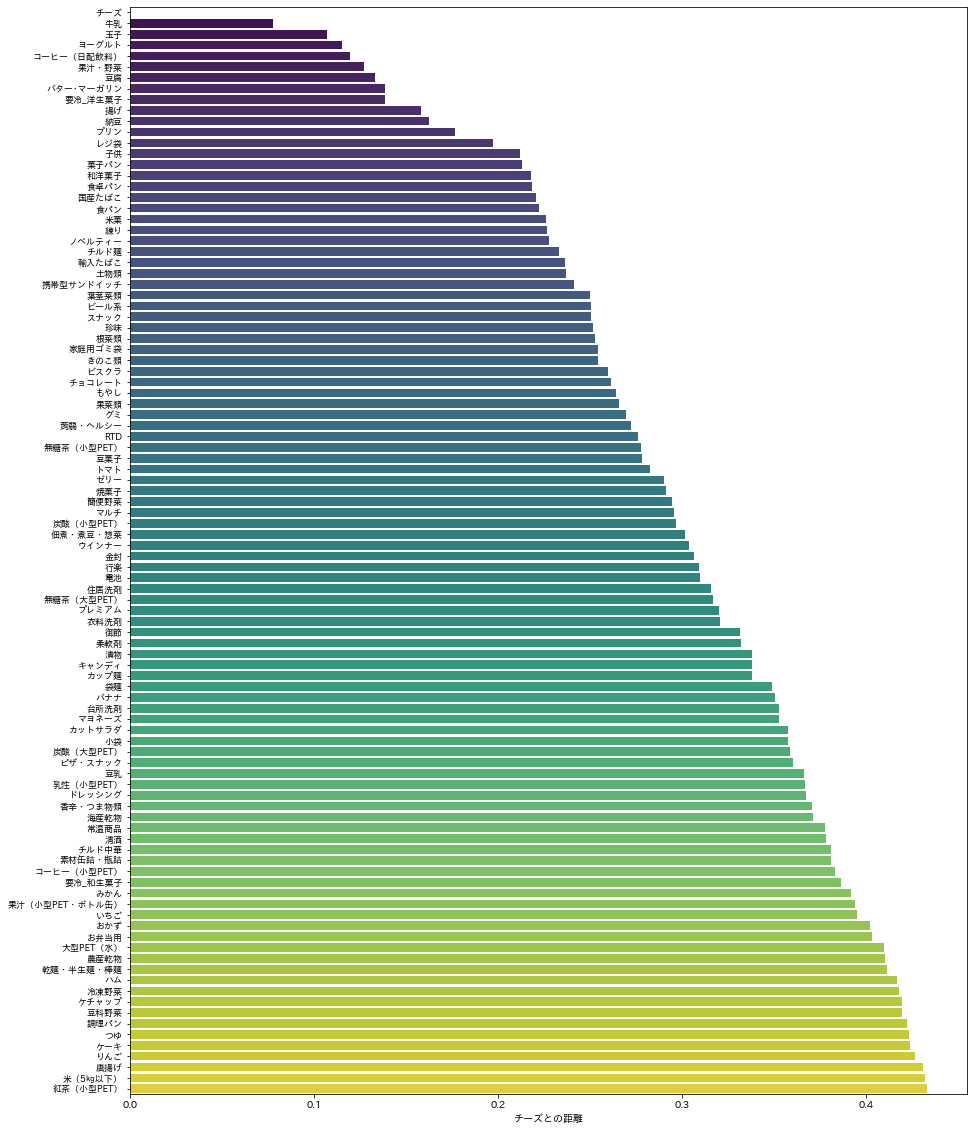

In [9]:
# top100
top_cheeze_df = cheeze_df.head(100)
fig, ax = plt.subplots(figsize=(15, 20))
ax.set_yticklabels(top_cheeze_df.index, fontsize=9)

sns.barplot(y=top_cheeze_df.index, 
            x=top_cheeze_df['チーズとの距離'], 
            ax=ax, 
            palette='viridis')

### 多次元尺度法でカテゴリの地図を作ってみる.
なんとなく意味のある距離行列になっていそうです。

> n個体間の非類似度または距離が与えられているとき、それらn個体の位置関係を（低次元の）座標で表現する手法として、多次元尺度法 (MDS : Multi-Dimensional Scaling) があります。
- [参考](https://qiita.com/roki18d/items/5927ce2d80006a9e35d5)

In [10]:
# 若干対照じゃない部分があるため、対照行列に変換
dist_mat_df[dist_mat_df.columns] = np.tril(dist_mat_df) + np.tril(dist_mat_df).T

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)
pos = mds.fit_transform(dist_mat_df.astype(np.float32))

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
for (x, y, name) in tqdm(zip(pos[:,0], pos[:, 1], dist_mat_df.index), total=len(dist_mat_df)):
        if name == 'チーズ':
            ax.plot(x,y, marker='o', color='r', markersize=8, alpha=0.5)
            ax.annotate(name, xy=(x, y), fontsize=8, color='r')
        else:
            ax.plot(x,y, marker='o', color='b', alpha=0.2, markersize=4)
            ax.annotate(name, xy=(x, y), fontsize=6)

ax.axis('off')
ax.set_xlim(-0.15, 0.4)
ax.set_ylim(-1, 1)
fig.savefig('dist_mat.jpg')

  0%|          | 0/499 [00:00<?, ?it/s]

ValueError: Image size of 554850x89337 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 720x720 with 1 Axes>

## どう使うか？

session毎に購入したカテゴリ毎のベクトル平均や分散を取ることで、そのsessionがどんな買い物だったのかということを表す特徴量が作成できます。  
平均はユーザーが通った場所の重心、分散はユーザーが通った範囲のようなものを表すような特徴になるかもしれません。

In [ ]:
dist_mat_df.index.name = 'category'
cat_columns = dist_mat_df.columns
log_df = log_df.merge(dist_mat_df, how='left', on='category')

In [ ]:
log_df.groupby('session_id')[cat_columns].mean()

,AVパーツ,おかず,おにぎり,キッチンスポンジ,ビスクラ,ビール系,ヘアケア,レジ袋,事務小物,入浴剤,...,資材,ベビー（おもちゃ）,座椅子,吊下げ,売上扱い,男児トレンド,植物,模造紙,種,額ボード
session_id,,,,,,,,,,,,,,,,,,,,,
00003ee1b7f34620ae81dba533c6d5a544513004fe5688b2a88560e071799c0e,15.743515,0.705525,0.736886,0.949519,0.520021,0.614781,1.498511,0.457800,3.978634,0.789876,...,23.498511,38.457800,69.569996,7.691327,40.457800,80.684929,45.475741,83.512056,4.817978,92.569996
00011e97d485ffb7f78662972da6032d4103b1628d541f8f0b916fc011a592e6,15.616626,0.575585,0.490662,0.822630,0.377233,0.596816,1.235999,0.330912,3.851745,0.662987,...,23.235999,38.330912,69.443107,7.600120,40.386054,80.555406,45.405557,83.385167,4.685131,92.443107
000280d2156d179a597167b269a69e5af556725eeaabae21226d755f73bf0bd9,15.400559,0.500302,0.414319,0.606563,0.177065,0.415974,1.158699,0.114845,3.635678,0.446920,...,23.158699,38.114845,69.227040,7.478988,40.205213,80.257857,45.231761,83.169100,4.475022,92.227040
0002a4a49d2230456ce57f9709b7c97e1ee324906f4ed8993b579d0ef0ed6135,15.836547,0.879236,0.778852,1.042552,0.608990,0.845479,1.274090,0.550833,4.071666,0.856343,...,23.274090,38.550833,69.644302,7.880620,40.634717,80.773102,45.659320,83.605088,4.906253,92.644302
000383cb2018d041d4976a0e26d2dc0b73918abd5a30c94179441f321aa598c0,15.573257,0.428323,0.515859,0.779261,0.336923,0.475431,1.331397,0.287543,3.808376,0.619619,...,23.331397,38.287543,69.399738,7.478392,40.287543,80.465922,45.301690,83.341798,4.620710,92.399738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffc962b9f45b0059808e4911a71a88e278afd156116ef8f0e2d07983b605718,15.409359,0.365251,0.345149,0.615363,0.140306,0.390414,1.167499,0.123645,3.644478,0.455720,...,23.167499,38.123645,69.235840,7.407653,40.182580,80.366694,45.204223,83.177900,4.460306,92.235840
fffd70401bffc2d2b7c5980bce4d373d693f6ffa26f0bbe03837bcc6ddd46c25,15.569551,0.587139,0.509572,0.775555,0.335463,0.557321,1.319325,0.283837,3.804670,0.615912,...,23.319325,38.283837,69.396032,7.580489,40.347105,80.445738,45.364804,83.338092,4.645762,92.396032
fffd9fafd8f535a35e4a5d526298c9ae4bf102d4329a6d8434815b6e0cad272d,15.667928,0.755422,0.681688,0.873932,0.444434,0.683343,1.426068,0.382213,3.903047,0.714289,...,23.426068,38.382213,69.494409,7.744362,40.472581,80.436865,45.499130,83.436469,4.745773,92.494409


## 今後の取り組み
- 距離の定義を考え直す。
    - 今回は遷移の時間と遷移回数の商を距離としましたが別の定義も考えられそうです。
- caegory以外もベクトル化する
    - 商品名、action_name、action_detailも同様の方法でベクトル化が可能です。
- 買い物の総距離を特徴量とする。
    - カテゴリの距離行列を用いて1回の買い物の総距離を求めることができます。  
    - 総距離とその買い物を行う際の最短経路長との差を取ることで、その買い物が計画的に行われたものであるのか、無計画に行われたものであるのかという特徴を表すことができるかもしれません。